<a href="https://colab.research.google.com/github/KormazovaVer/Lab_1/blob/main/Lab_2_Kormazova_VO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Виртуальный датчик Ссылка на данные: https://drive.google.com/drive/folders/1Yknvpep7H1MSXIG5q5s7P68rF8mjIe_s?usp=sharing

В файле target_lec - хранится информация о неком важном химическом показателе в клинкере (продукт на выходе из вращающейся печи)

В файле data_lec - все имеющиеся признаки, среди которых данные телеметрии (с датчиков оборудования) и химических анализов сырья, из которого получается клинкер.

Необходимо:

1. Построить виртуальный датчик (ВД) показателя в таргете, который сможет расчитывать значение в настоящий момент времени,  что существенно снизит нагрузку на лабораторию и даст возможность оператору быстрее реагировать на изменения в процессе.

2. Построить прогнозную модель, которая на горизонте в 15 минут может установить значение таргета.

3*. Построить модель, которая может определить значение таргета в случае изменения показателя gas_consumption1 на шаг 150 (текущее значение + 150) в последующие 15 минут.  
Из названий фичей можно примерно понять их физическую природу(не все они полезны и информативны).

Ограничений в использовании алгоритмов и подходов нет.

Одна из основных бизнес целей - не пропускать моменты, когда таргет опускается ниже 1. и поднимается выше 2.

Сдавать в виде ссылки на гитхаб, на гит данные не выкладывать

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [87]:
from google.colab import drive
# Подключение Google Диска
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
# Копирование файла из каталога Google Диска в текущее рабочее пространство
!cp /content/drive/MyDrive/data_lec.csv /content/

!cp /content/drive/MyDrive/target_lec.csv /content/

In [89]:
# Чтение данных
target_lec = pd.read_csv('target_lec.csv')
data_lec = pd.read_csv('data_lec.csv')

### Анализ данных

In [90]:
data_lec.head()

,Unnamed: 0,timestamp,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1
0,0,2023-09-04 05:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006982,NaN,NaN
1,1,2023-09-04 05:02:00+00:00,NaN,767.616089,301.616760,NaN,4.334852,0.338180,0.0,0.0,...,NaN,NaN,27.0,NaN,781.098145,NaN,NaN,0.018020,NaN,NaN
2,2,2023-09-04 05:03:00+00:00,NaN,767.758545,302.511932,NaN,4.304109,0.388817,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.015809,NaN,NaN
3,3,2023-09-04 05:04:00+00:00,NaN,767.806030,303.645836,NaN,4.303205,0.353552,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.013946,NaN,NaN
4,4,2023-09-04 05:05:00+00:00,NaN,767.806000,304.222733,NaN,4.290545,0.349031,0.0,0.0,...,NaN,NaN,27.0,NaN,780.870209,NaN,NaN,0.023489,NaN,NaN


In [91]:
data_lec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81255 entries, 0 to 81254
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              81255 non-null  int64  
 1   timestamp               81255 non-null  object 
 2   ppm1                    80284 non-null  float64
 3   temp1                   80639 non-null  float64
 4   temp2                   80639 non-null  float64
 5   ppm2                    80284 non-null  float64
 6   gas_opening1            80639 non-null  float64
 7   press1                  80639 non-null  float64
 8   rotationspeed1          80639 non-null  float64
 9   press3                  80639 non-null  float64
 10  temp3                   80639 non-null  float64
 11  press2                  80639 non-null  float64
 12  press4                  80639 non-null  float64
 13  temp4                   80639 non-null  float64
 14  electric_ampere1        80639 non-null

In [92]:
missing_per_column = data_lec.isnull().sum()
print("Количество пропущенных значений по столбцам:")
print(missing_per_column)

Количество пропущенных значений по столбцам:
Unnamed: 0                    0
timestamp                     0
ppm1                        971
temp1                       616
temp2                       616
ppm2                        971
gas_opening1                616
press1                      616
rotationspeed1              616
press3                      616
temp3                       616
press2                      616
press4                      616
temp4                       616
electric_ampere1            616
speed1                      616
press5                      616
electric_consumption2       616
press6                      616
speed2                      616
electric_consumption3       616
inlet_pressure1             616
press7                      616
gas_consumption1            616
press8                      616
press9                      616
electric_consumption4       616
electric_consumption5       616
press10                     616
sito1                      

In [93]:
missing_percentage_per_column = data_lec.isnull().mean() * 100
missing_percentage_per_column_rounded = missing_percentage_per_column.round(2)
print("Процент пропущенных значений по столбцам (округлено до сотых):")
print(missing_percentage_per_column_rounded)


Процент пропущенных значений по столбцам (округлено до сотых):
Unnamed: 0                 0.00
timestamp                  0.00
ppm1                       1.20
temp1                      0.76
temp2                      0.76
ppm2                       1.20
gas_opening1               0.76
press1                     0.76
rotationspeed1             0.76
press3                     0.76
temp3                      0.76
press2                     0.76
press4                     0.76
temp4                      0.76
electric_ampere1           0.76
speed1                     0.76
press5                     0.76
electric_consumption2      0.76
press6                     0.76
speed2                     0.76
electric_consumption3      0.76
inlet_pressure1            0.76
press7                     0.76
gas_consumption1           0.76
press8                     0.76
press9                     0.76
electric_consumption4      0.76
electric_consumption5      0.76
press10                    0.76
sito1    

In [94]:
target_lec.head()

,timestamp,target
0,2023-09-06 07:17:00+00:00,0.99480
1,2023-09-06 08:46:00+00:00,1.98218
2,2023-09-06 11:24:00+00:00,2.29000
3,2023-09-06 13:21:00+00:00,2.13000
4,2023-09-06 14:53:00+00:00,1.15249


In [95]:
target_lec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  158 non-null    object 
 1   target     158 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.6+ KB


In [96]:
missing_per_column = target_lec.isnull().sum()
print("Количество пропущенных значений по столбцам:")
print(missing_per_column)

Количество пропущенных значений по столбцам:
timestamp    0
target       0
dtype: int64


In [97]:
# Преобразование столбца timestamp в datetime
data_lec['timestamp'] = pd.to_datetime(data_lec['timestamp'])
target_lec['timestamp'] = pd.to_datetime(target_lec['timestamp'])

In [98]:
# Объединяем датафреймы по 'timestamp'
combined_data = data_lec.merge(target_lec, on='timestamp', how='left', suffixes=('', '_target'))

# Объединяем столбцы target в один
combined_data['final_target'] = (
    combined_data['target']
    .fillna(combined_data['target_target'])
    .fillna(combined_data['target_ffill'])
)

# Удаляем лишние столбцы target
combined_data.drop(['target', 'target_ffill', 'target_target'], axis=1, inplace=True)

# Проверяем результат
print(combined_data.head())


   Unnamed: 0                 timestamp  ppm1       temp1       temp2  ppm2  \
0           0 2023-09-04 05:01:00+00:00   NaN         NaN         NaN   NaN   
1           1 2023-09-04 05:02:00+00:00   NaN  767.616089  301.616760   NaN   
2           2 2023-09-04 05:03:00+00:00   NaN  767.758545  302.511932   NaN   
3           3 2023-09-04 05:04:00+00:00   NaN  767.806030  303.645836   NaN   
4           4 2023-09-04 05:05:00+00:00   NaN  767.806000  304.222733   NaN   

   gas_opening1    press1  rotationspeed1  press3  ...  CaO2  SIM2  LSF2  \
0           NaN       NaN             NaN     NaN  ...   NaN   NaN   NaN   
1      4.334852  0.338180             0.0     0.0  ...   NaN   NaN   NaN   
2      4.304109  0.388817             0.0     0.0  ...   NaN   NaN   NaN   
3      4.303205  0.353552             0.0     0.0  ...   NaN   NaN   NaN   
4      4.290545  0.349031             0.0     0.0  ...   NaN   NaN   NaN   

   electric_ampere2  electric_ampere3       temp5  electric_ampere_d

In [99]:
print(combined_data.columns)

Index(['Unnamed: 0', 'timestamp', 'ppm1', 'temp1', 'temp2', 'ppm2',
       'gas_opening1', 'press1', 'rotationspeed1', 'press3', 'temp3', 'press2',
       'press4', 'temp4', 'electric_ampere1', 'speed1', 'press5',
       'electric_consumption2', 'press6', 'speed2', 'electric_consumption3',
       'inlet_pressure1', 'press7', 'gas_consumption1', 'press8', 'press9',
       'electric_consumption4', 'electric_consumption5', 'press10', 'sito1',
       'moisture1', 'ALM1', 'CaO1', 'SIM1', 'LSF1', 'sito2', 'moisture2',
       'ALM2', 'CaO2', 'SIM2', 'LSF2', 'electric_ampere2', 'electric_ampere3',
       'temp5', 'electric_ampere_delta1', 'coeffs_current1', 'coeffs_temp1',
       'final_target'],
      dtype='object')


In [100]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81255 entries, 0 to 81254
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   Unnamed: 0              81255 non-null  int64              
 1   timestamp               81255 non-null  datetime64[ns, UTC]
 2   ppm1                    80284 non-null  float64            
 3   temp1                   80639 non-null  float64            
 4   temp2                   80639 non-null  float64            
 5   ppm2                    80284 non-null  float64            
 6   gas_opening1            80639 non-null  float64            
 7   press1                  80639 non-null  float64            
 8   rotationspeed1          80639 non-null  float64            
 9   press3                  80639 non-null  float64            
 10  temp3                   80639 non-null  float64            
 11  press2                  80639 non-null  f

<ipython-input-101-2f1b5fd28480>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correlation_with_target_sorted.index,


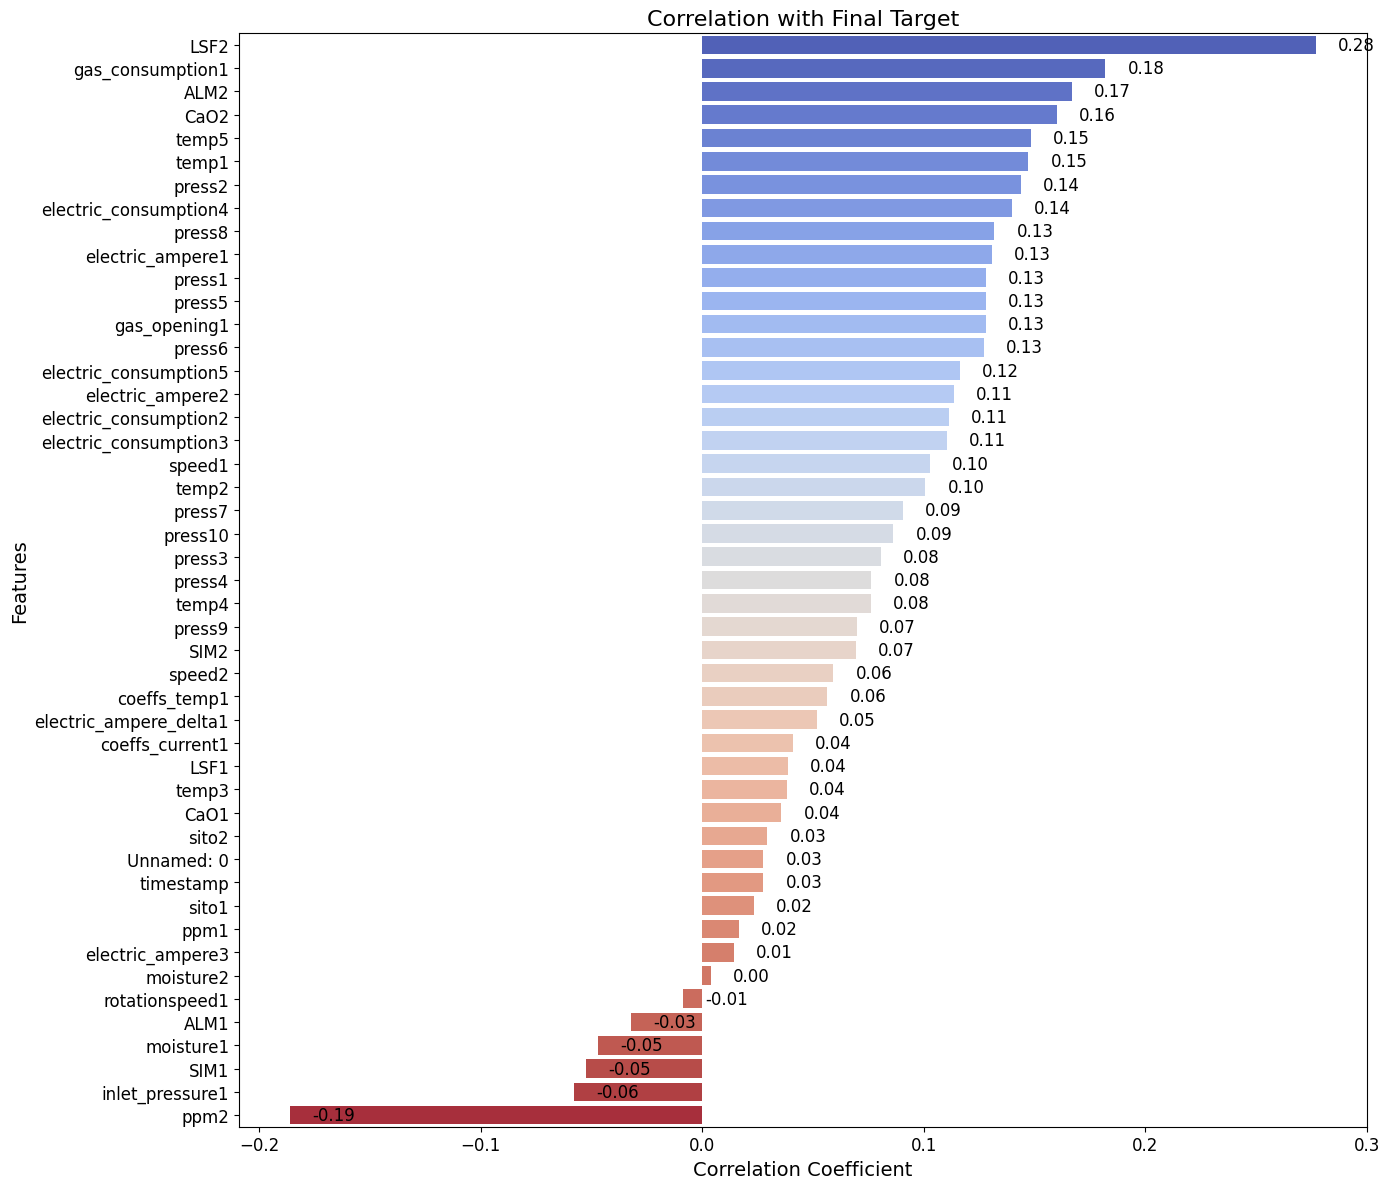

In [101]:
# Рассчитываем корреляцию всех признаков с final_target
correlation_with_target = combined_data.corr()['final_target'].drop('final_target')

# Визуализация корреляции с final_target
plt.figure(figsize=(14, 12))
correlation_with_target_sorted = correlation_with_target.sort_values(ascending=False)

sns.barplot(y=correlation_with_target_sorted.index,
            x=correlation_with_target_sorted,
            palette="coolwarm",
            orient='h')  # Горизонтальная ориентация

plt.title("Correlation with Final Target", fontsize=16)
plt.xlabel("Correlation Coefficient", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Добавление значений корреляции на график
for i, (feature, corr) in enumerate(correlation_with_target_sorted.items()):
    plt.text(corr + 0.01, i, f'{corr:.2f}', va='center', ha='left', fontsize=12, color='black')

plt.show()


In [102]:
# Рассчитываем корреляцию всех признаков с 'final_target'
correlation_with_target = combined_data.corr()['final_target']

# Фильтруем признаки, оставляя только те, у которых корреляция больше 0.1 или меньше -0.1
filtered_features = correlation_with_target[abs(correlation_with_target) > 0.1]

# Список столбцов, которые нужно оставить
columns_to_keep = filtered_features.index.tolist()

# Включаем 'timestamp' и 'final_target', чтобы они оставались в итоговом датафрейме
columns_to_keep.extend(['timestamp'])

# Создаем новый датафрейм с отфильтрованными признаками
filtered_combined_data = combined_data[columns_to_keep]

# Проверяем результат
print(filtered_combined_data.head())


        temp1       temp2  ppm2  gas_opening1    press1    press2  \
0         NaN         NaN   NaN           NaN       NaN       NaN   
1  767.616089  301.616760   NaN      4.334852  0.338180  0.339988   
2  767.758545  302.511932   NaN      4.304109  0.388817  0.310149   
3  767.806030  303.645836   NaN      4.303205  0.353552  0.330042   
4  767.806000  304.222733   NaN      4.290545  0.349031  0.323712   

   electric_ampere1    speed1    press5  electric_consumption2  ...    press8  \
0               NaN       NaN       NaN                    NaN  ...       NaN   
1          0.026835  0.119900  4.334852                    0.0  ...  5.931861   
2          0.027164  0.119629  4.304109                    0.0  ...  5.909097   
3          0.031936  0.119900  4.303205                    0.0  ...  5.913792   
4          0.032496  0.119358  4.290545                    0.0  ...  5.926197   

   electric_consumption4  electric_consumption5  ALM2  CaO2  LSF2  \
0                    NaN     

In [103]:
filtered_combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81255 entries, 0 to 81254
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   temp1                  80639 non-null  float64            
 1   temp2                  80639 non-null  float64            
 2   ppm2                   80284 non-null  float64            
 3   gas_opening1           80639 non-null  float64            
 4   press1                 80639 non-null  float64            
 5   press2                 80639 non-null  float64            
 6   electric_ampere1       80639 non-null  float64            
 7   speed1                 80639 non-null  float64            
 8   press5                 80639 non-null  float64            
 9   electric_consumption2  80639 non-null  float64            
 10  press6                 80639 non-null  float64            
 11  electric_consumption3  80639 non-null  float64        

In [104]:
filtered_combined_data.interpolate(method='linear', inplace=True)
filtered_combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81255 entries, 0 to 81254
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   temp1                  81254 non-null  float64            
 1   temp2                  81254 non-null  float64            
 2   ppm2                   80899 non-null  float64            
 3   gas_opening1           81254 non-null  float64            
 4   press1                 81254 non-null  float64            
 5   press2                 81254 non-null  float64            
 6   electric_ampere1       81254 non-null  float64            
 7   speed1                 81254 non-null  float64            
 8   press5                 81254 non-null  float64            
 9   electric_consumption2  81254 non-null  float64            
 10  press6                 81254 non-null  float64            
 11  electric_consumption3  81254 non-null  float64        

<ipython-input-104-2d24731d3469>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_data.interpolate(method='linear', inplace=True)


In [105]:
filtered_combined_data.fillna(method='ffill', inplace=True)  # Прямое заполнение
filtered_combined_data.fillna(method='bfill', inplace=True)  # Обратное заполнение

<ipython-input-105-75c752d56973>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_combined_data.fillna(method='ffill', inplace=True)  # Прямое заполнение
<ipython-input-105-75c752d56973>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_combined_data.fillna(method='ffill', inplace=True)  # Прямое заполнение
<ipython-input-105-75c752d56973>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_combined_data.fillna(method='bfill', inplace=True)  # Обратное заполнение
<ipython-input-105-75c752d56973>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

In [106]:
filtered_combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81255 entries, 0 to 81254
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   temp1                  81255 non-null  float64            
 1   temp2                  81255 non-null  float64            
 2   ppm2                   81255 non-null  float64            
 3   gas_opening1           81255 non-null  float64            
 4   press1                 81255 non-null  float64            
 5   press2                 81255 non-null  float64            
 6   electric_ampere1       81255 non-null  float64            
 7   speed1                 81255 non-null  float64            
 8   press5                 81255 non-null  float64            
 9   electric_consumption2  81255 non-null  float64            
 10  press6                 81255 non-null  float64            
 11  electric_consumption3  81255 non-null  float64        

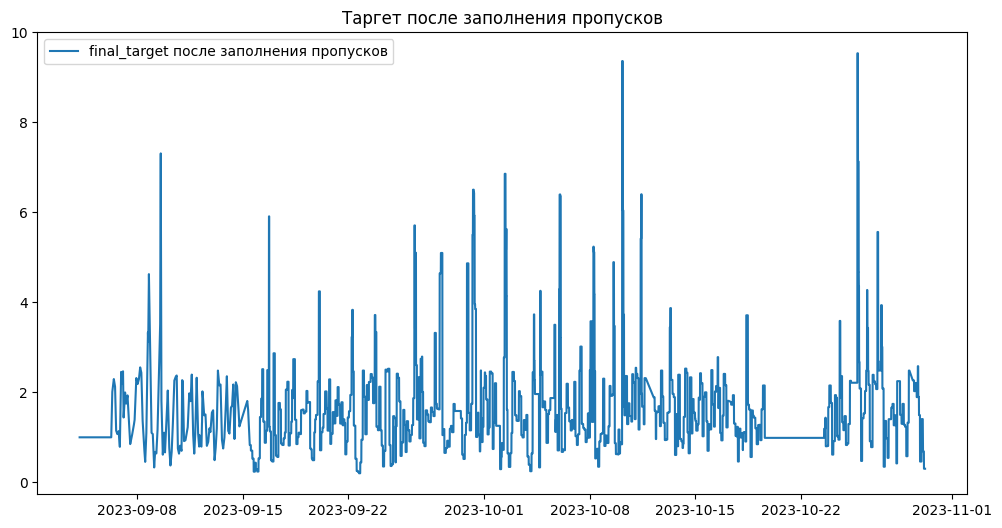

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_combined_data["timestamp"], filtered_combined_data["final_target"], label="final_target после заполнения пропусков")
plt.title("Таргет после заполнения пропусков")
plt.legend()
plt.show()

<ipython-input-108-1b81f18149b2>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correlation_target_sorted.index,


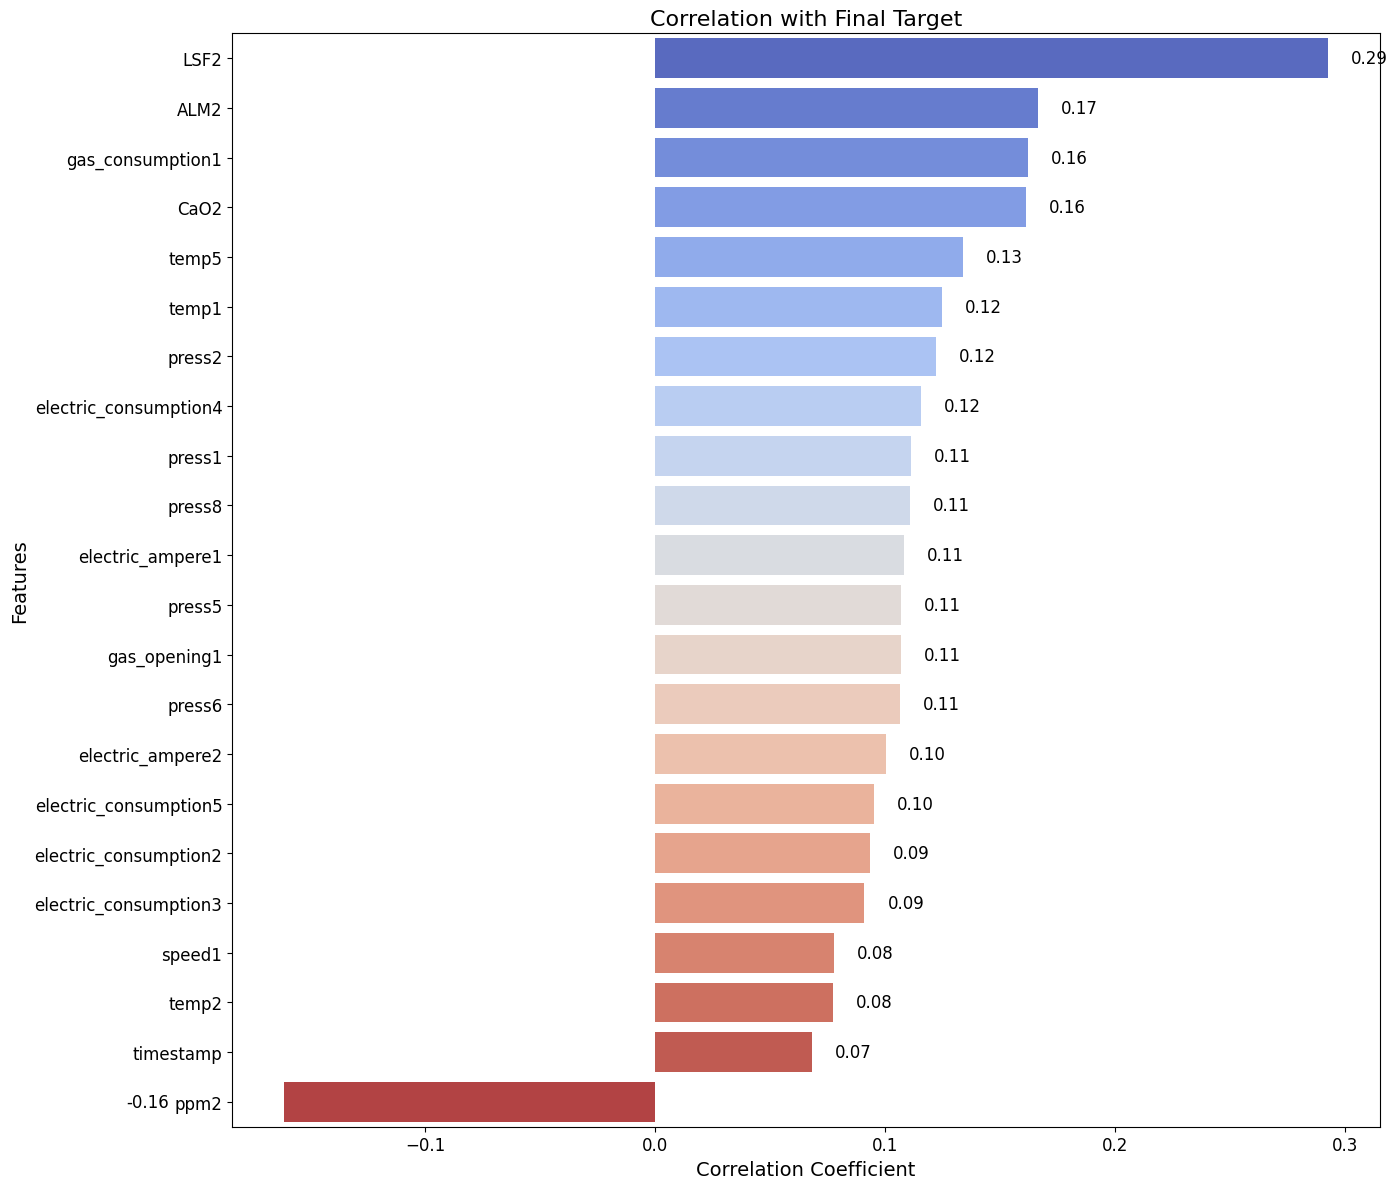

In [108]:
# Рассчитываем корреляцию всех признаков с 'final_target'
correlation_target = filtered_combined_data.corr()['final_target'].drop('final_target')

# Визуализация корреляции с 'final_target'
plt.figure(figsize=(14, 12))
correlation_target_sorted = correlation_target.sort_values(ascending=False)

sns.barplot(y=correlation_target_sorted.index,
            x=correlation_target_sorted.values,
            palette="coolwarm",
            orient='h')  # Горизонтальная ориентация

plt.title("Correlation with Final Target", fontsize=16)
plt.xlabel("Correlation Coefficient", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Добавление значений корреляции на график
for i, (feature, corr) in enumerate(correlation_target_sorted.items()):
    plt.text(corr + 0.01 if corr > 0 else corr - 0.05, i, f'{corr:.2f}',
             va='center', ha='left' if corr > 0 else 'right', fontsize=12, color='black')

plt.show()

In [109]:
columns_to_drop = [
    'temp2',
    'speed1',
    'electric_consumption3',
    'electric_consumption2',
    'electric_consumption5',
    'electric_ampere2'
]

data_final = filtered_combined_data.drop(columns=columns_to_drop)

In [110]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81255 entries, 0 to 81254
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   temp1                  81255 non-null  float64            
 1   ppm2                   81255 non-null  float64            
 2   gas_opening1           81255 non-null  float64            
 3   press1                 81255 non-null  float64            
 4   press2                 81255 non-null  float64            
 5   electric_ampere1       81255 non-null  float64            
 6   press5                 81255 non-null  float64            
 7   press6                 81255 non-null  float64            
 8   gas_consumption1       81255 non-null  float64            
 9   press8                 81255 non-null  float64            
 10  electric_consumption4  81255 non-null  float64            
 11  ALM2                   81255 non-null  float64        

In [40]:
lag_features = [1, 2, 3]
for lag in lag_features:
    data_final[f"target_lag_{lag}"] = data_final["final_target"].shift(lag)

key_features = ["LSF2", "ALM2", "gas_consumption1", "CaO2"]
for feature in key_features:
    for lag in lag_features:
        data_final[f"{feature}_lag_{lag}"] = data_final[feature].shift(lag)

data_final = data_final.dropna().reset_index(drop=True)

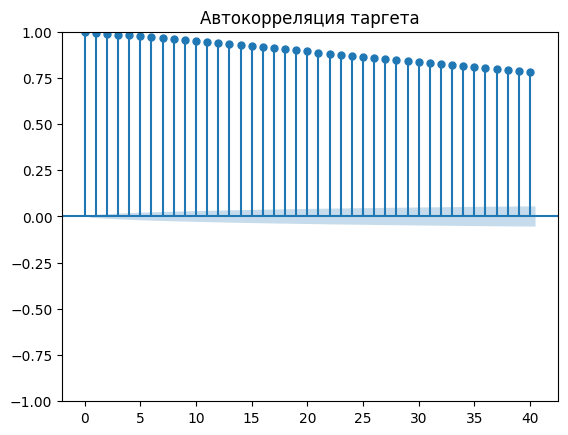

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_final["final_target"], lags=40)
plt.title("Автокорреляция таргета")
plt.show()

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data_final["final_target"], model="additive", period=24)

data_final["target_trend"] = result.trend
data_final["target_seasonal"] = result.seasonal
data_final["target_residual"] = result.resid

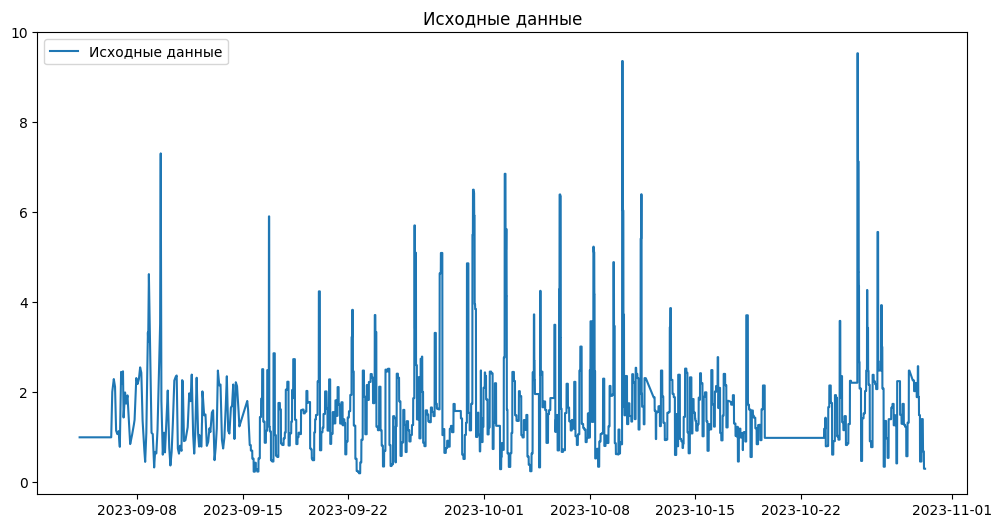

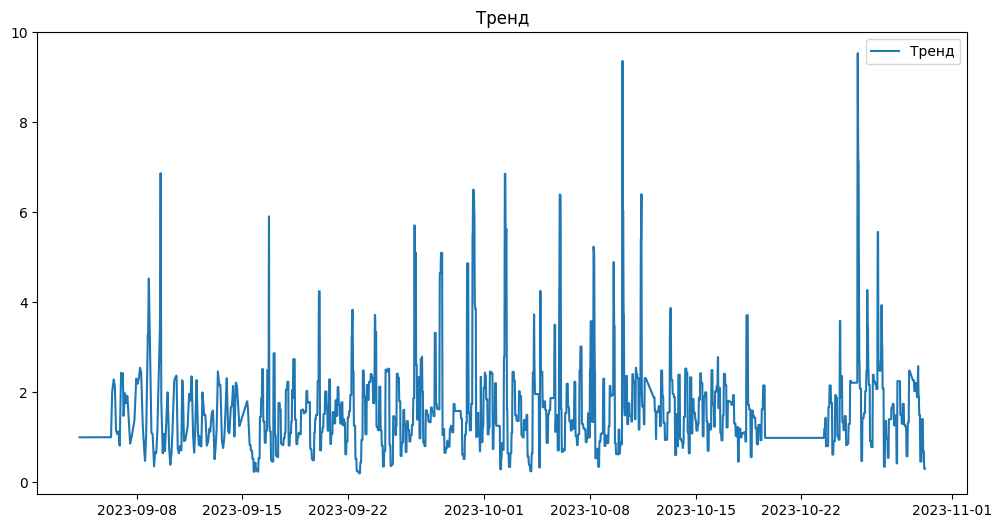

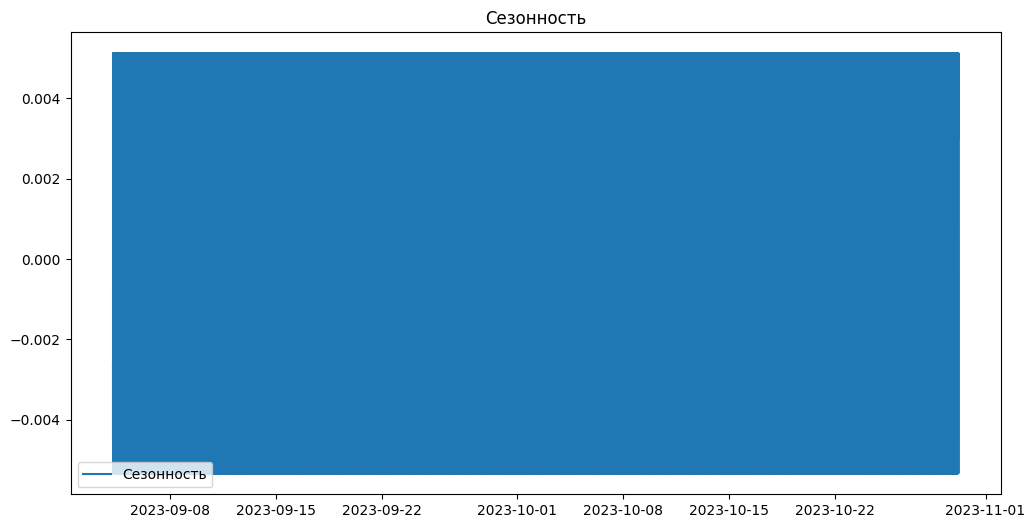

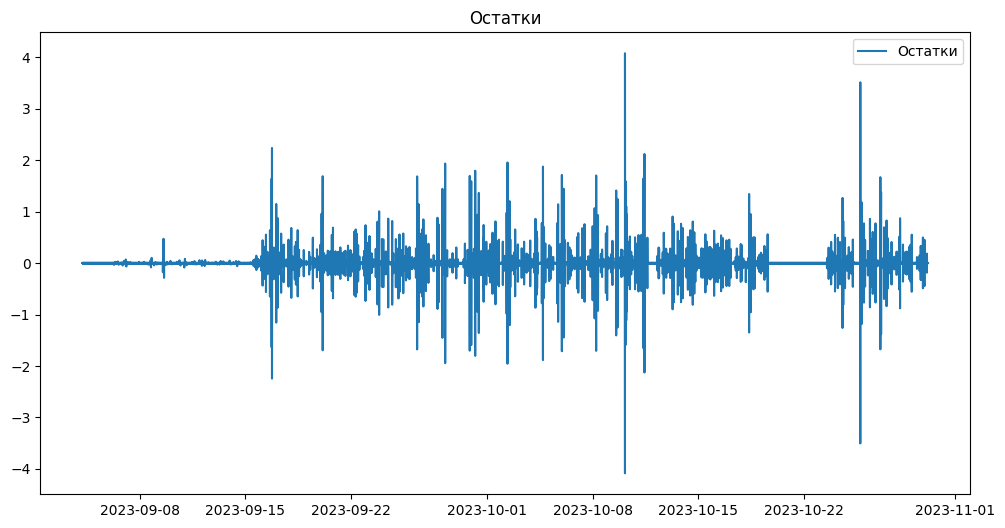

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(data_final["timestamp"], data_final["final_target"], label="Исходные данные")
plt.title("Исходные данные")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data_final["timestamp"], data_final["target_trend"], label="Тренд")
plt.title("Тренд")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data_final["timestamp"], data_final["target_seasonal"], label="Сезонность")
plt.title("Сезонность")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data_final["timestamp"], data_final["target_residual"], label="Остатки")
plt.title("Остатки")
plt.legend()
plt.show()

Среднее значение остатков: 0.000000
Стандартное отклонение остатков: 0.135776


<Figure size 1000x600 with 0 Axes>

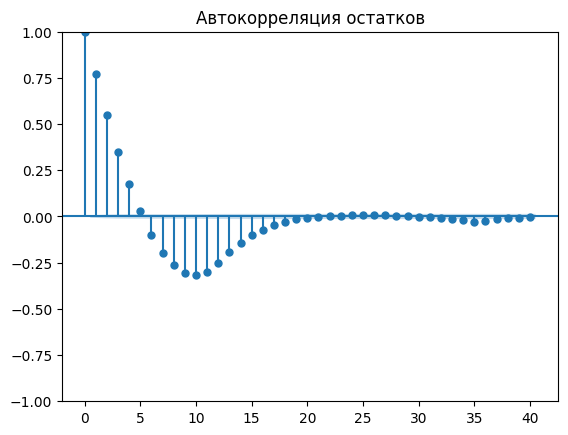

In [45]:
resid_mean = data_final["target_residual"].mean()
resid_std = data_final["target_residual"].std()

print(f"Среднее значение остатков: {resid_mean:.6f}")
print(f"Стандартное отклонение остатков: {resid_std:.6f}")

plt.figure(figsize=(10, 6))
plot_acf(data_final["target_residual"].dropna(), lags=40)
plt.title("Автокорреляция остатков")
plt.show()

При анализе данных выполнены несколько задач обработки временного ряда данных, включая объединение данных, предобработку, анализ корреляции, создание признаков, временную декомпозицию и визуализацию:

1. Чтение и преобразование данных:  
Чтение данных из файлов CSV в датафреймы: target_lec и data_lec.
Преобразование столбцов timestamp в формат datetime для упрощения временных операций.  

2. Объединение и обработка данных:  
Объединение датафреймов data_lec и target_lec по ключу timestamp посредством левого соединения, чтобы сохранить все строки из data_lec.
Компиляция столбцов target в единый столбец final_target, заполняя пропуски приоритетно из target_target, затем из target_ffill.
Удаление ненужных столбцов для упрощения структуры данных.

3. Анализ корреляции и визуализация:  
Расчет корреляции всех признаков с final_target.
Визуализация корреляции с помощью горизонтального столбчатого графика для наглядного отображения значений.

4. Фильтрация признаков:  
Фильтрация признаков оставляя только те, у которых корреляция с final_target больше 0.1 по модулю.
Обновление датафрейма filtered_combined_data с отфильтрованными признаками.

5. Обработка и интерполяция данных:  
Интерполяция пропущенных данных линейным методом и заполнение отсутствующих значений с использованием прямого и обратного заполнения.
Повторный расчет корреляции и визуализация этих данных после фильтрации и интерполяции.

6. Создание новых признаков с запаздыванием:   
Добавление лагов к final_target и ключевым признакам (LSF2, ALM2, gas_consumption1, CaO2), позволяющее учесть временные зависимости.

7. Анализ автокорреляции и декомпозиция:  
Построение графика автокорреляции для временного ряда final_target.
Временная декомпозиция ряда final_target на компоненты: тренд, сезонность и остатки.

8. Визуализация временных компонентов:  
Визуализация оригинальных данных и всех компонентов временной декомпозиции (тренд, сезонность, остатки), что позволяет лучше понять структуру временного ряда и его поведение.

9. Анализ остатков:
Практически нулевое среднее значение остатков указывает на то, что в среднем прогнозы или компоненты модели корректны и централизованы относительно истинных значений.  Остатки следуют нормальному распределению и их хвосты быстро затухают, следовательно не остается значительных аномалий или автокорреляции.

Выводы:    
 Данные подготовлены для дальнейшего обучения, признаки с низкой корреляцией (<=0.1 и <=-0.1) к final_target удалены, добавлены временные лаги к признакам с наибольшей корреляцией (LSF2, ALM2, gas_consumption1, CaO2) с final_target. Нормальное распределение остатков при невысокой автокорреляции означает, что основная работа с улавливанием подтекста и глобальных паттернов в данных выполнена корректно.

### Задание 1

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Разделение данных на признаки и целевую переменную
X = data_final.drop(['timestamp', 'final_target'], axis=1)
y = data_final['final_target']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Оценка модели на тестовой выборке
y_test_pred = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

print(f'Test MAE: {mae_test}')
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')

# Оценка модели на обучающей выборке
y_train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)

print(f'Train MAE: {mae_train}')
print(f'Train RMSE: {rmse_train}')
print(f'Train R²: {r2_train}')

# Создание таблицы для визуализации предсказаний на тестовой выборке
results_df = pd.DataFrame({'Настоящие значения': y_test, 'Предсказанные значения': y_test_pred})
print("Таблица результатов (RandomForest) на тестовой выборке")
print(results_df.head())


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test MAE: 0.006362160563244108
Test RMSE: 0.04800057078788286
Test R²: 0.9974786094995987
Train MAE: 0.0045319774952505805
Train RMSE: 0.02179202647069976
Train R²: 0.9994757375577841
Таблица результатов (RandomForest) на тестовой выборке
       Настоящие значения  Предсказанные значения
43106            0.567540                0.564264
5535             2.196183                2.200357
61169            2.015130                2.017781
72200            1.759210                1.757569
80355            2.202870                2.205150


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [53]:

# Создание таблицы для визуализации предсказаний на тестовой выборке
results_df = pd.DataFrame({'Настоящие значения': y_test, 'Предсказанные значения': y_test_pred})
results_df[:20]

,Настоящие значения,Предсказанные значения
43106,0.567540,0.564264
5535,2.196183,2.200357
61169,2.015130,2.017781
72200,1.759210,1.757569
80355,2.202870,2.205150
57458,1.512210,1.516062
52194,9.362980,9.362980
40221,1.250710,1.250912
51838,1.167820,1.163168
56486,0.943830,0.939229


На основе полученных метрик можно сделать следующие выводы о качестве модели RandomForestRegressor:

Тестовая выборка:
1. MAE (средняя абсолютная ошибка): 0.0064  
Это обозначает, что в среднем абсолютное отклонение предсказанных значений от фактических равно 0.0064, показывая достаточно высокую точность модели, так как ошибка мала.  
2. RMSE (корень из среднеквадратичной ошибки): 0.0480  
RMSE чуть выше MAE, отражая, что более крупные редкие ошибки влияют на общее качество модели, но этот показатель также мал.  
3. R² (коэффициент детерминации): 0.9975  
Значение близкое к 1 указывает на то, что модель объясняет 99.75% дисперсии в тестовых данных, что свидетельствует о почти идеальном согласовании модели с данными.  

Обучающая выборка:  
1. MAE: 0.0045  
Средняя абсолютная ошибка на обучающей выборке ниже, чем на тестовой, показывая высокую точность модели при прогнозировании на обучающей выборке.  
2. RMSE: 0.0218  
RMSE для обучающей выборки также ниже, что подтверждает высокую точность модели на обучающих данных.  
3. R²: 0.9995  
Этот коэффициент близок к 1 и говорит о том, что модель объясняет 99.95% дисперсии в обучающих данных, демонстрируя почти идеальное соответствие.  
  
Заключение:  
1. Разница в ошибках: ошибки на тестовой выборке выше, чем на обучающей, но все равно малы и приемлемы, свидетельствуя о хорошем качестве модели. Высокий R² на обеих выборках указывает на то, что модель очень хорошо справляется с прогнозированием и мало склонна к переобучению.  
2. Способность модели: модель представляет собой мощный инструмент для предсказания, успешно отображая тенденции и закономерности в данных.
Эти результаты показывают, что у модели хорошо сбалансированы обучение и обобщение, что особенно важно для стабильного поведения на новых, невиданных данных.  


### Задание 2

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt

In [112]:
# Создаем целевой признак, сдвинутый на 15 шагов вперед
data_final['target_shifted'] = data_final['final_target'].shift(-15)

In [113]:
# Удаляем строки с NaN в target_shifted
data_final.dropna(subset=['target_shifted'], inplace=True)

In [114]:
# Создаем лаги для временного ряда
for lag in range(1, 16):
    data_final[f'target_lag_{lag}'] = data_final['final_target'].shift(lag)

In [115]:
# Добавляем временные признаки: час и день недели
data_final['hour'] = data_final['timestamp'].dt.hour
data_final['day_of_week'] = data_final['timestamp'].dt.dayofweek

In [116]:
# Вычисляем скользящие средние и стандартные отклонения
for window in [5, 15, 20]:
    data_final[f'rolling_mean_{window}'] = data_final['final_target'].rolling(window=window).mean()
    data_final[f'rolling_std_{window}'] = data_final['final_target'].rolling(window=window).std()

In [117]:
# Удаляем возможные NaN, образовавшиеся из-за лагов и скользящих окон
data_final.dropna(inplace=True)

In [118]:
# Определяем признаки и целевую переменную
feature_columns = [col for col in data_final.columns if col not in ['timestamp', 'final_target', 'target_shifted']]

In [119]:
# Создаем матрицу признаков из указанных колонок
X_future = data_final[feature_columns]

# Создаем вектор целевых значений из сдвинутого столбца
y_future = data_final['target_shifted']


In [120]:
# Заполняем пропуски
imputer = SimpleImputer(strategy='mean')
X_future = imputer.fit_transform(X_future)

In [121]:
# Разделение на обучающие и тестовые наборы
X_train_future, X_test_future, y_train_future, y_test_future = train_test_split(X_future, y_future, test_size=0.2, random_state=42, shuffle=False)

In [67]:
# Прогнозная модель на 15 шагов вперед
model_future = GradientBoostingRegressor()
model_future.fit(X_train_future, y_train_future)

GradientBoostingRegressor()

In [68]:
# Предсказание на тестовом наборе
y_pred_future = model_future.predict(X_test_future)

In [69]:
# Оценка модели
mae = mean_absolute_error(y_test_future, y_pred_future)
rmse = mean_squared_error(y_test_future, y_pred_future, squared=False)
r2 = r2_score(y_test_future, y_pred_future)

print(f"MAE (средняя абсолютная ошибка): {mae:.4f}")
print(f"RMSE (корень из среднеквадратичной ошибки): {rmse:.4f}")
print(f"R^2 (коэффициент детерминации): {r2:.4f}")

MAE (средняя абсолютная ошибка): 0.0702
RMSE (корень из среднеквадратичной ошибки): 0.2723
R^2 (коэффициент детерминации): 0.9147


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [77]:
# Определение критических зон и MAE для них
critical_zones = (y_test_future < 1) | (y_test_future > 2)
critical_mae = mean_absolute_error(y_test_future[critical_zones], y_pred_future[critical_zones])
print(f"Критическая зона MAE: {critical_mae:.4f}")

Критическая зона MAE: 0.0781


In [80]:
# Создание таблицы для визуализации предсказаний на тестовой выборке
results_df = pd.DataFrame({'Настоящие значения': y_test_future, 'Предсказанные значения': y_pred_future})

# Вывод 10 случайных строк из таблицы результатов
random_sample = results_df.sample(n=10, random_state=42)
print(random_sample)

       Настоящие значения  Предсказанные значения
67871             0.98258                0.998444
67784             0.98258                0.998444
66661             0.98258                1.001344
65839             2.14796                2.125388
78574             2.24390                2.122055
80221             2.02176                2.017443
75429             1.52858                1.517286
78504             0.41483                0.446793
66725             0.98258                1.001344
65065             1.19580                1.211770


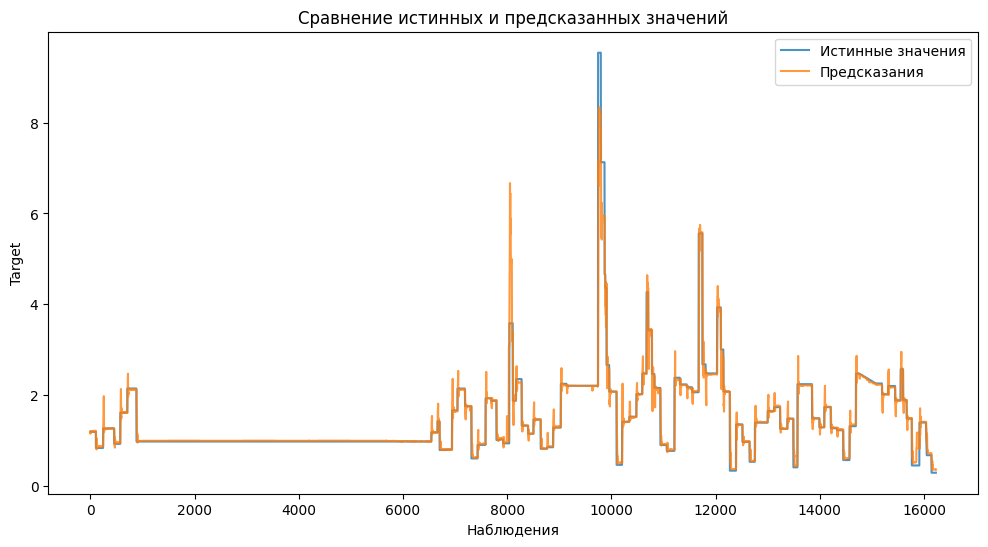

In [76]:
# Визуализация сравнения истинных и предсказанных значений
plt.figure(figsize=(12, 6))
plt.plot(y_test_future.reset_index(drop=True), label='Истинные значения', alpha=0.8)
plt.plot(y_pred_future, label='Предсказания', alpha=0.8)
plt.title('Сравнение истинных и предсказанных значений')
plt.xlabel('Наблюдения')
plt.ylabel('Target')
plt.legend()
plt.show()

После обучения модели с помощью GradientBoostingRegressor получены следующие метрики обучения:

Метрики оценки модели:  
1. Средняя абсолютная ошибка (MAE): 0.0702  
В среднем, предсказанные значения отклоняются от фактических на 0.0702 единицы. Это свидетельствует о приемлемой точности модели.  
Корень из среднеквадратичной ошибки (RMSE): 0.2723  
2. RMSE немного выше MAE, что указывает на то, что более крупные ошибки имеют большее влияние. Тем не менее, значение все еще низкое, что подтверждает хорошее качество модели.  
3. Коэффициент детерминации (R²): 0.9147  
Значение R² близкое к 1 указывает на то, что модель объясняет 91.47% дисперсии в данных. Это говорит об отличном согласовании модели с данными.  
4. Критическая зона MAE: 0.0781  
Здесь ошибка немного выше, в определённых "критических" зонах, что обычно служит индикатором того, что модель предсказывает хуже для определенных значений, когда фактические значения небольшие или выходят за верхнюю границу, например от 0 и до 1 и после 2.  

Вывод: модель демонстрирует хорошее предсказание по большинству данных, но с немного более высокими ошибками в определенных (критических) зонах данных.

### Задание 3

In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

In [137]:
# Определение X и y
feature_columns = [col for col in data_final.columns if col not in ['timestamp', 'final_target', 'target_shifted']]
X = data_final[feature_columns]
y = data_final['target_shifted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [181]:
# Обучение и предсказание
model_current = GradientBoostingRegressor()
model_current.fit(X_train, y_train)
y_pred = model_current.predict(X_test)

In [182]:
# Оценка модели
mae_current = mean_absolute_error(y_test, y_pred)
rmse_current = np.sqrt(mean_squared_error(y_test, y_pred))
r2_current = r2_score(y_test, y_pred)

print(f"MAE (средняя абсолютная ошибка): {mae_current:.4f}")
print(f"RMSE (корень из среднеквадратичной ошибки): {rmse_current:.4f}")
print(f"R^2 (коэффициент детерминации): {r2_current:.4f}")

MAE (средняя абсолютная ошибка): 0.1217
RMSE (корень из среднеквадратичной ошибки): 0.3854
R^2 (коэффициент детерминации): 0.8294


In [175]:
# Ошибка для критических зон
critical_zones = (y_test < 1) | (y_test > 2)
critical_mae = mean_absolute_error(y_test[critical_zones], y_pred[critical_zones])
print(f"Критическая зона MAE: {critical_mae:.4f}")

Критическая зона MAE: 0.1271


In [141]:
# Modifying 'gas_consumption1_modified' for effect analysis
X_test_effect = X_test.copy()
gas_consumption_index = X_test_effect.columns.get_loc('gas_consumption1_modified')
X_test_effect.iloc[:, gas_consumption_index] += 150

In [142]:
# Предсказание с измененными данными
y_pred_effect = model_current.predict(X_test_effect)
effect_rmse = np.sqrt(mean_squared_error(y_test, y_pred_effect))
print(f"Влияние изменения 'gas_consumption1_modified', RMSE: {effect_rmse:.4f}")

Влияние изменения 'gas_consumption1_modified', RMSE: 0.3795


In [143]:
# Создание таблицы для визуализации предсказаний на тестовой выборке
results_df = pd.DataFrame({'Настоящие значения': y_test.values, 'Предсказанные значения': y_pred})

# Вывод 10 случайных строк из таблицы результатов
random_sample = results_df.sample(n=10, random_state=42)
print(random_sample)

       Настоящие значения  Предсказанные значения
9334              2.20846                2.107154
5902              0.98258                0.944007
7926              0.94259                1.237030
16122             0.68130                0.700585
12128             3.00587                2.809104
4602              0.98258                1.007314
6032              0.98258                0.977883
3978              0.98258                0.998353
7475              0.90840                0.972554
8451              1.15353                1.171334


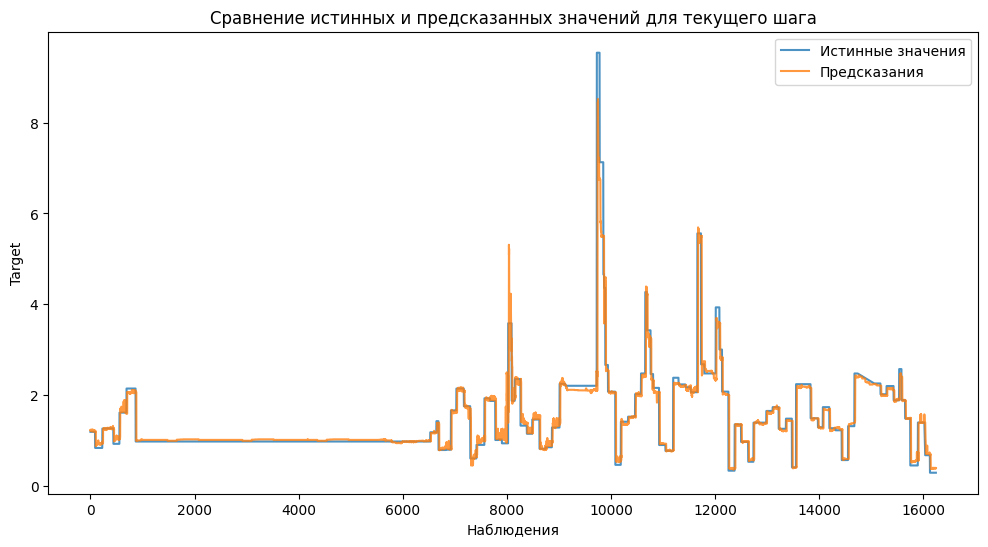

In [134]:
# Графики сравнения истинных и предсказанных значений и значимости признаков
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Истинные значения', alpha=0.8)
plt.plot(y_pred, label='Предсказания', alpha=0.8)
plt.title('Сравнение истинных и предсказанных значений для текущего шага')
plt.xlabel('Наблюдения')
plt.ylabel('Target')
plt.legend()
plt.show()



Полученные значения метрик позволяют сделать следующие выводы о модели:

1. MAE (средняя абсолютная ошибка): 0.1217  
Значение 0.1217 говорит о том, что предсказания модели в среднем ошибаются на 0.1217 единиц в шкале целевой переменной.
2. RMSE (корень из среднеквадратичной ошибки): 0.3854   
RMSE  выше, чем MAE, что может указывать на наличие некоторых значительных ошибок в предсказаниях, но его уровень 0.3854 всё еще указывает на достаточно точные модельные предсказания при учёте масштаба данных.  
3. R^2 (коэффициент детерминации): 0.8294   
Значение R^2 показывает долю дисперсии зависимой переменной, которая объясняется моделью. Значение 0.8294 указывает на то, что модель объясняет около 82.94% вариации целевой переменной. Это, как правило, считается хорошим показателем, означая, что модель хорошо справляется с объяснением зависимости в данных.  
4. Критическая зона MAE: 0.1271  
Показатель MAE равный 0.1271 в критических зонах означает, что в условиях, которые считаются критическими (например, когда целевая переменная меньше 1 или больше 2), модель ошибается в среднем на 0.1271, что не сильно отличается от общего MAE в 0.1217. Это указывает на то, что в критических зонах модель также показывает стабильную точность.  

Выводы:
В целом, модель демонстрирует хорошую точность и обладает высокой объяснительной способностью, о чем свидетельствуют значения MAE, RMSE и
R^2. Модель показывает стабильную точность не только в общем, но и в заранее определенных критических условиях.